In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np
from os.path  import join
from tqdm.notebook import tqdm


%matplotlib inline
import matplotlib.pyplot as plt
from helpers import *
from lenslets import *
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

import sys
sys.path.append('..')
from extended_fov_helpers import * 

from skimage.transform import rescale, resize

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../recon')
import recon.load_scripts_extended as loading
from recon.helper_fns_extended import *

# Choose CPU or GPU here:
%run ../recon/fista_spectral_cupy.py CPU #GPU

IDEAL_PATH = '/Users/clarahung/repos/extendedfov/design/IDEAL_psfs'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device =  CPU , using CPU and numpy


<Figure size 640x480 with 0 Axes>

## MNIST

100%|██████████| 9.91M/9.91M [00:06<00:00, 1.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 334kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.95MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 359kB/s]


(100, 84, 84)

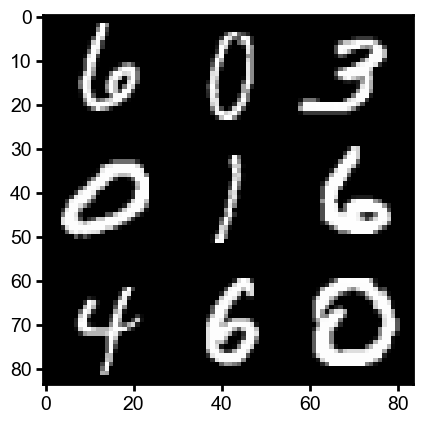

In [ ]:
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # converts RGB -> 1 channel
    transforms.ToTensor(),                         # converts to [0,1] float tensor
])
train_dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=transform)

x_train = torch.stack([img for img, _ in train_dataset])  # shape: [60000, 1, 28, 28]
x_test  = torch.stack([img for img, _ in test_dataset])   # shape: [10000, 1, 28, 28]

# Remove channel dimension if needed
x_train = x_train.squeeze(1)  # [60000, 28, 28]
x_test  = x_test.squeeze(1)   # [10000, 28, 28]

x_train = torch.nn.functional.pad(x_train, (2, 2, 2, 2), mode='constant', value=0)  # pads 2 pixels on H and W
x_test  = torch.nn.functional.pad(x_test,  (2, 2, 2, 2), mode='constant', value=0)

# Normalize to 0-1 (already 0-1 from ToTensor, but ensures max=1)
x_train = x_train / x_train.max()
x_test  = x_test  / x_test.max()

num_tiles = 100
mnist_tiles = make_image_tiles_torch(x_train, grid_size=3, num_grids=num_tiles).numpy()
plt.imshow(mnist_tiles[1], cmap='gray')

### Load Lenslets

In [ ]:
psf = np.load(os.path.join('/Users/clarahung/repos/extendedfov/design/IDEAL_psfs/ideal_mnist_psf.npy'))
mse_lst = []
psnr_lst = []
ssim_lst = []
for (j, tile_img) in enumerate(tqdm(mnist_tiles, desc="Tiles")):
    lens_path = './ideal/mnist/measurements/'
    if not os.path.exists(lens_path):
        os.mkdir(lens_path)
    name = 'img_{}'.format(j)

    conv_img, img_save_path, f_name = forward(tile_img, psf, psf_name='ideal', name=name, gray=True, crop=False, save_path=lens_path)

    ## RECON
    results_path = './ideal/mnist/results/lens_{}/'
    if not os.path.exists(results_path):
        os.mkdir(results_path)

    psf, img, mask = preprocess('/Users/clarahung/repos/extendedfov/design/IDEAL_psfs/ideal_mnist_psf.npy', img_save_path, f=1, gray_image=False)
    ## Recon Parameters
    fista = fista_spectral_numpy(psf[:,:,1:2], mask[:,:,1:2], gray=False) # green channel only

    # set FISTA parameters
    fista.iters = 100
    fista.prox_method = 'tv'  
    fista.tv_lambda  = 1e-2 #1e-3, 1e-2, 1e-1
    fista.tv_lambdaw = 0.01
    fista.print_every = 100

    ## Run FISTA
    out_img = fista.run(img)

    ## Display Results
    cropped = out_img[0][0]
    uncropped = out_img[0][1]

    cropped_name = f'cropped_{f_name}'
    uncropped_name = f'uncropped_{f_name}'

    fig = plt.figure()
    plt.imshow(preplot(cropped))
    plt.axis('off') 
    plt.imsave(results_path + cropped_name + '.png', preplot(cropped))


    plt.figure()
    plt.imshow(preplot(uncropped))
    plt.axis('off') 
    plt.imsave(results_path + uncropped_name + '.png', preplot(uncropped))

    np.save(results_path + cropped_name + '.npy', cropped)
    np.save(results_path + uncropped_name + '.npy', uncropped)

    uncropped = uncropped[:, :, 0] 
    uncropped = np.clip(uncropped, 0, 1)

    ### COMPUTE METRICS
    mse_lst.append(mean_squared_error(tile_img, uncropped))
    psnr_lst.append(peak_signal_noise_ratio(tile_img, uncropped, data_range=1))
    ssim_lst.append(structural_similarity(tile_img, uncropped, data_range=1))

    np.save('./ideal/mnist/results/' + 'ssim.npy', np.array(ssim_lst))
    np.save('./ideal/mnist/results/' + 'psnr.npy', np.array(psnr_lst))
    np.save('./ideal/mnist/results/' + 'mse.npy', np.array(mse_lst))

### Copy cells below and adapt to your use case for plotting

In [4]:
### This is for the graph of metrics vs lenslets

metrics = [total_mse_lst, total_psnr_lst, total_ssim_lst]
names = ["MSE vs Number of Lenslets", "PSNR vs Number of Lenslets", "SSIM vs Number of Lenslets"]

plot_metrics_with_ci(metrics, names)

NameError: name 'total_mse_lst' is not defined

In [ ]:
# this is for the 3x3 grid of results

# Lenslet indices to plot
lenslet_indices = list(range(9))  # [0, 1, 2, ..., 8]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()  # Flatten so we can index with a single loop

for ax, lens_idx in zip(axes, lenslet_indices):
    img_path = f'./cifar10/results/lens_{lens_idx}/uncropped_img_99-lenslet_{lens_idx}-measurement.png'
    img = plt.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Lenslet {lens_idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## FASHION

In [ ]:
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # converts RGB -> 1 channel
    transforms.ToTensor(),                         # converts to [0,1] float tensor
])
train_dataset = datasets.FashionMNIST(root='./data/FASHION', train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root='./data/FASHION', train=False, download=True, transform=transform)

x_train = torch.stack([img for img, _ in train_dataset])  # shape: [60000, 1, 28, 28]
x_test  = torch.stack([img for img, _ in test_dataset])   # shape: [10000, 1, 28, 28]

# Remove channel dimension if needed
x_train = x_train.squeeze(1)  # [60000, 28, 28]
x_test  = x_test.squeeze(1)   # [10000, 28, 28]

x_train = torch.nn.functional.pad(x_train, (2, 2, 2, 2), mode='constant', value=0)  # pads 2 pixels on H and W
x_test  = torch.nn.functional.pad(x_test,  (2, 2, 2, 2), mode='constant', value=0)

# Normalize to 0-1 (already 0-1 from ToTensor, but ensures max=1)
x_train = x_train / x_train.max()
x_test  = x_test  / x_test.max()

num_tiles = 100
fashion_tiles = make_image_tiles_torch(x_train, grid_size=3, num_grids=num_tiles).numpy()
plt.imshow(fashion_tiles[1], cmap='gray')

In [ ]:
psf = np.load(os.path.join('/Users/clarahung/repos/extendedfov/design/IDEAL_psfs/ideal_fashion_psf.npy'))
mse_lst = []
psnr_lst = []
ssim_lst = []
for (j, tile_img) in enumerate(tqdm(fashion_tiles, desc="Tiles")):
    lens_path = './ideal/fashion/measurements/'
    if not os.path.exists(lens_path):
        os.mkdir(lens_path)
    name = 'img_{}'.format(j)

    conv_img, img_save_path, f_name = forward(tile_img, psf, psf_name='ideal', name=name, gray=True, crop=False, save_path=lens_path)

    ## RECON
    results_path = './ideal/fashion/results/lens_{}/'
    if not os.path.exists(results_path):
        os.mkdir(results_path)

    psf, img, mask = preprocess('/Users/clarahung/repos/extendedfov/design/IDEAL_psfs/ideal_fashion_psf.npy', img_save_path, f=1, gray_image=False)
    ## Recon Parameters
    fista = fista_spectral_numpy(psf[:,:,1:2], mask[:,:,1:2], gray=False) # green channel only

    # set FISTA parameters
    fista.iters = 100
    fista.prox_method = 'tv'  
    fista.tv_lambda  = 1e-2 #1e-3, 1e-2, 1e-1
    fista.tv_lambdaw = 0.01
    fista.print_every = 100

    ## Run FISTA
    out_img = fista.run(img)

    ## Display Results
    cropped = out_img[0][0]
    uncropped = out_img[0][1]

    cropped_name = f'cropped_{f_name}'
    uncropped_name = f'uncropped_{f_name}'

    fig = plt.figure()
    plt.imshow(preplot(cropped))
    plt.axis('off') 
    plt.imsave(results_path + cropped_name + '.png', preplot(cropped))


    plt.figure()
    plt.imshow(preplot(uncropped))
    plt.axis('off') 
    plt.imsave(results_path + uncropped_name + '.png', preplot(uncropped))

    np.save(results_path + cropped_name + '.npy', cropped)
    np.save(results_path + uncropped_name + '.npy', uncropped)

    uncropped = uncropped[:, :, 0] 
    uncropped = np.clip(uncropped, 0, 1)

    ### COMPUTE METRICS
    mse_lst.append(mean_squared_error(tile_img, uncropped))
    psnr_lst.append(peak_signal_noise_ratio(tile_img, uncropped, data_range=1))
    ssim_lst.append(structural_similarity(tile_img, uncropped, data_range=1))

    np.save('./ideal/fashion/results/' + 'ssim.npy', np.array(ssim_lst))
    np.save('./ideal/fashion/results/' + 'psnr.npy', np.array(psnr_lst))
    np.save('./ideal/fashion/results/' + 'mse.npy', np.array(mse_lst))

## CIFAR

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # converts RGB -> 1 channel
    transforms.ToTensor(),                         # converts to [0,1] float tensor
])
train_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, download=False, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=False, transform=transform)

x_train = torch.stack([img for img, _ in train_dataset])  # shape: [60000, 1, 28, 28]
x_test  = torch.stack([img for img, _ in test_dataset])   # shape: [10000, 1, 28, 28]

# Remove channel dimension if needed
x_train = x_train.squeeze(1)  # [60000, 28, 28]
x_test  = x_test.squeeze(1)   # [10000, 28, 28]

# Normalize to 0-1 (already 0-1 from ToTensor, but ensures max=1)
x_train = x_train / x_train.max()
x_test  = x_test  / x_test.max()

num_tiles = 100
cifar_tiles = make_image_tiles_torch(x_train, grid_size=3, num_grids=num_tiles).numpy()
plt.imshow(cifar_tiles[1], cmap='gray')
cifar_tiles.shape

In [ ]:
psf = np.load(os.path.join('/Users/clarahung/repos/extendedfov/design/IDEAL_psfs/ideal_cifar_psf.npy'))
mse_lst = []
psnr_lst = []
ssim_lst = []
for (j, tile_img) in enumerate(tqdm(cifar_tiles, desc="Tiles")):
    lens_path = './ideal/cifar/measurements/'
    if not os.path.exists(lens_path):
        os.mkdir(lens_path)
    name = 'img_{}'.format(j)

    conv_img, img_save_path, f_name = forward(tile_img, psf, psf_name='ideal', name=name, gray=True, crop=False, save_path=lens_path)

    ## RECON
    results_path = './ideal/cifar/results/lens_{}/'
    if not os.path.exists(results_path):
        os.mkdir(results_path)

    psf, img, mask = preprocess('/Users/clarahung/repos/extendedfov/design/IDEAL_psfs/ideal_cifar_psf.npy', img_save_path, f=1, gray_image=False)
    ## Recon Parameters
    fista = fista_spectral_numpy(psf[:,:,1:2], mask[:,:,1:2], gray=False) # green channel only

    # set FISTA parameters
    fista.iters = 100
    fista.prox_method = 'tv'  
    fista.tv_lambda  = 1e-2 #1e-3, 1e-2, 1e-1
    fista.tv_lambdaw = 0.01
    fista.print_every = 100

    ## Run FISTA
    out_img = fista.run(img)

    ## Display Results
    cropped = out_img[0][0]
    uncropped = out_img[0][1]

    cropped_name = f'cropped_{f_name}'
    uncropped_name = f'uncropped_{f_name}'

    fig = plt.figure()
    plt.imshow(preplot(cropped))
    plt.axis('off') 
    plt.imsave(results_path + cropped_name + '.png', preplot(cropped))


    plt.figure()
    plt.imshow(preplot(uncropped))
    plt.axis('off') 
    plt.imsave(results_path + uncropped_name + '.png', preplot(uncropped))

    np.save(results_path + cropped_name + '.npy', cropped)
    np.save(results_path + uncropped_name + '.npy', uncropped)

    uncropped = uncropped[:, :, 0] 
    uncropped = np.clip(uncropped, 0, 1)

    ### COMPUTE METRICS
    mse_lst.append(mean_squared_error(tile_img, uncropped))
    psnr_lst.append(peak_signal_noise_ratio(tile_img, uncropped, data_range=1))
    ssim_lst.append(structural_similarity(tile_img, uncropped, data_range=1))

    np.save('./ideal/cifar/results/' + 'ssim.npy', np.array(ssim_lst))
    np.save('./ideal/cifar/results/' + 'psnr.npy', np.array(psnr_lst))
    np.save('./ideal/cifar/results/' + 'mse.npy', np.array(mse_lst))